In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bbc-news/bbc_news.csv


# Intro

# Imports and minor setup

In [2]:
import pandas as pd

from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification

import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('expand_frame_repr', False)

# Loading the data and quick EDA

In [3]:
df: pd.DataFrame = pd.read_csv("/kaggle/input/bbc-news/bbc_news.csv")
print(df.columns)
# drop the columns we are not interested in
df: pd.DataFrame = df.drop(["guid", "link"], axis = 1)

# print the shape of the dataframe and the head
print(df.shape)
df.head

Index(['title', 'pubDate', 'guid', 'link', 'description'], dtype='object')
(27329, 3)


<bound method NDFrame.head of                                                    title                        pubDate                                        description
0      Ukraine: Angry Zelensky vows to punish Russian...  Mon, 07 Mar 2022 08:01:56 GMT  The Ukrainian president says the country will ...
1      War in Ukraine: Taking cover in a town under a...  Sun, 06 Mar 2022 22:49:58 GMT  Jeremy Bowen was on the frontline in Irpin, as...
2             Ukraine war 'catastrophic for global food'  Mon, 07 Mar 2022 00:14:42 GMT  One of the world's biggest fertiliser firms sa...
3      Manchester Arena bombing: Saffie Roussos's par...  Mon, 07 Mar 2022 00:05:40 GMT  The parents of the Manchester Arena bombing's ...
4      Ukraine conflict: Oil price soars to highest l...  Mon, 07 Mar 2022 08:15:53 GMT  Consumers are feeling the impact of higher ene...
...                                                  ...                            ...                                                .

# Preparing the Hugging Face transformers

In [4]:
modelName = "distilbert-base-uncased-finetuned-sst-2-english"

myTokenizer = AutoTokenizer.from_pretrained(modelName)
myModel = AutoModelForSequenceClassification.from_pretrained(modelName, max_length=2048)

classifier = pipeline("sentiment-analysis", model=myModel, tokenizer=myTokenizer)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

# Preparing the data

In [5]:
def computeSentimentScore(text):
    out = classifier(text)

    if out[0]['label'] == 'POSITIVE':
        return out[0]['score']
    else:
        return out[0]['score'] * -1

In [6]:
def isNewsOfInterest(text):
    for f in ["ukrain", "kiev", "kyiv", "odesa", "kherson", "zelensky", "zaluzhnyi", "budanov", "syrskyi"]:
        if f in text:
            return True

    return False

In [7]:
data = {}

for row in df.iterrows():
    text = (row[1]["title"] + row[1]["description"]).lower()
    if isNewsOfInterest(text):
        date = pd.to_datetime(row[1]["pubDate"])

        year = date.year
        week = date.week

        if year in data:
            if week in data[year]:
                found = data[year][week]
                foundCount = found["count"]
                data[year][week]["count"] = foundCount + 1
                data[year][week]["sentiment"].append(computeSentimentScore(text))
            else:
                foundMap = data[year]
                foundMap[week] = {"count": 1, "sentiment": [computeSentimentScore(text)]}
        else:
            data[year] = {week: {"count": 1, "sentiment": [computeSentimentScore(text)]}}

In [8]:
years = []
weeks = []
mentions = []
weekLabels = []
sentiments = []

for y in data:
    for w in data[y]:
        years.append(y)
        weeks.append(w)
        mentions.append(data[y][w]["count"])
        weekLabels.append(pd.to_datetime((y * 1000) + (w * 7), format='%Y%j').date())
        sentimentValues = data[y][w]["sentiment"]
        sentimentOfTheWeek = sum(sentimentValues) / len(sentimentValues)
        sentiments.append(sentimentOfTheWeek)

In [9]:
print(len(years), len(weeks), len(mentions), len(weekLabels), len(sentiments))

96 96 96 96 96


In [10]:
df = pd.DataFrame(
    {'year': years,
     'week': weeks,
     'mentions': mentions,
     'weekLabels': weekLabels,
     'sentiment': sentiments
    })

df = df.sort_values(by=['year', 'week'])
df = df.reset_index(drop=True)

In [11]:
print(df.head(100))
print(df.shape)

numberOfBins = 12

    year  week  mentions  weekLabels  sentiment
0   2022     9        22  2022-03-04  -0.374819
1   2022    10       158  2022-03-11  -0.416849
2   2022    11       104  2022-03-18  -0.560479
3   2022    12        72  2022-03-25  -0.697629
4   2022    13        56  2022-04-01  -0.504394
..   ...   ...       ...         ...        ...
91  2023    48         5  2023-12-02  -0.987849
92  2023    49         6  2023-12-09  -0.977327
93  2023    50        13  2023-12-16  -0.532334
94  2023    51         8  2023-12-23  -0.009403
95  2023    52        18  2023-12-30  -0.557149

[96 rows x 5 columns]
(96, 5)


# News mentions of the conflict

Text(0.5, 1.0, 'Mentions in the news, per week')

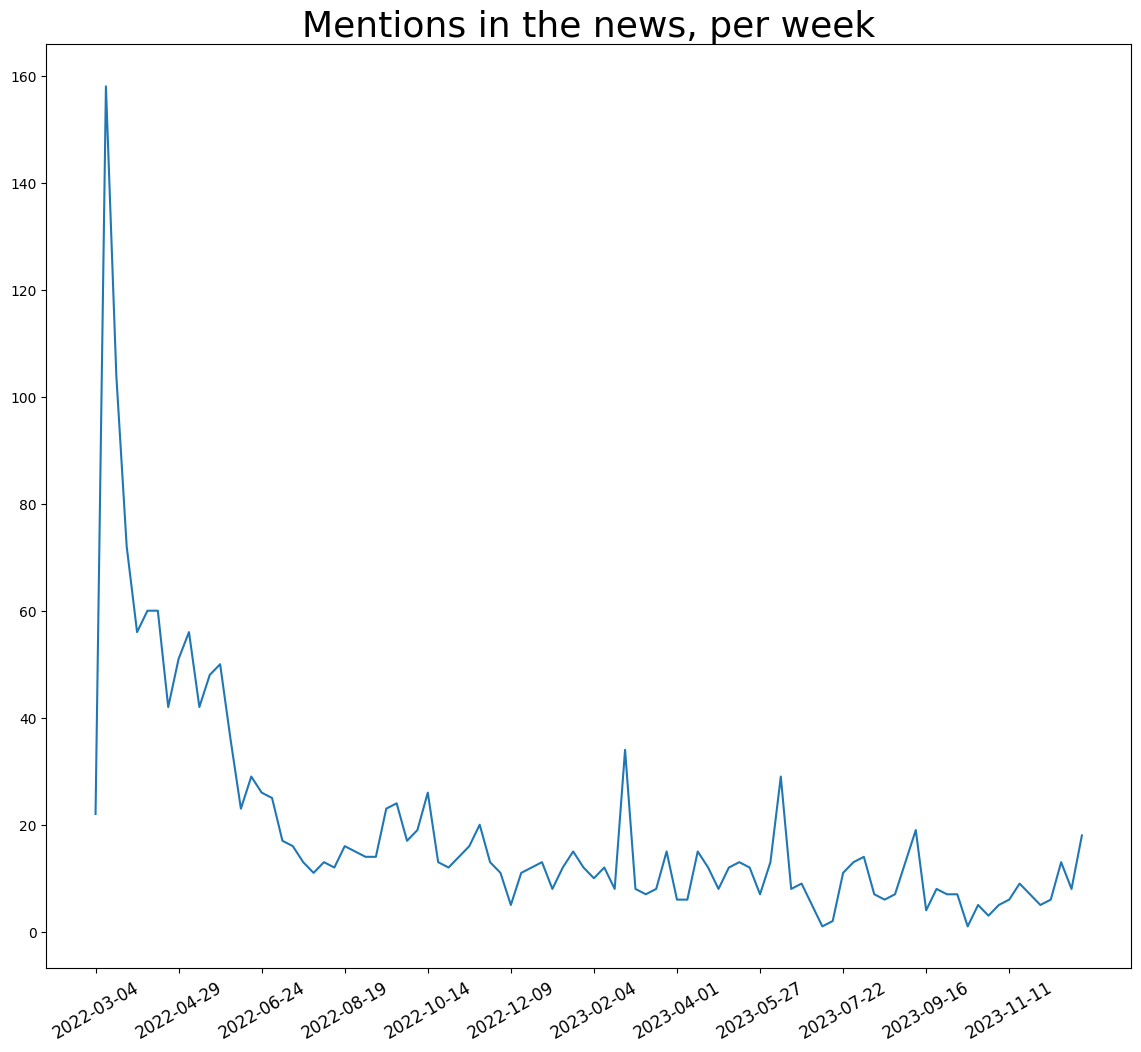

In [12]:
plt.figure(figsize=(14, 12))
df["mentions"].plot()
plt.xticks(range(len(df["weekLabels"])), df["weekLabels"], size='large')
plt.xticks(rotation = 30)
plt.locator_params(axis='x', nbins=numberOfBins)
plt.title('Mentions in the news, per week', fontsize = 26)

# News sentiment of the conflict

Text(0.5, 1.0, 'Sentiment of the news, per week, higher is more positive')

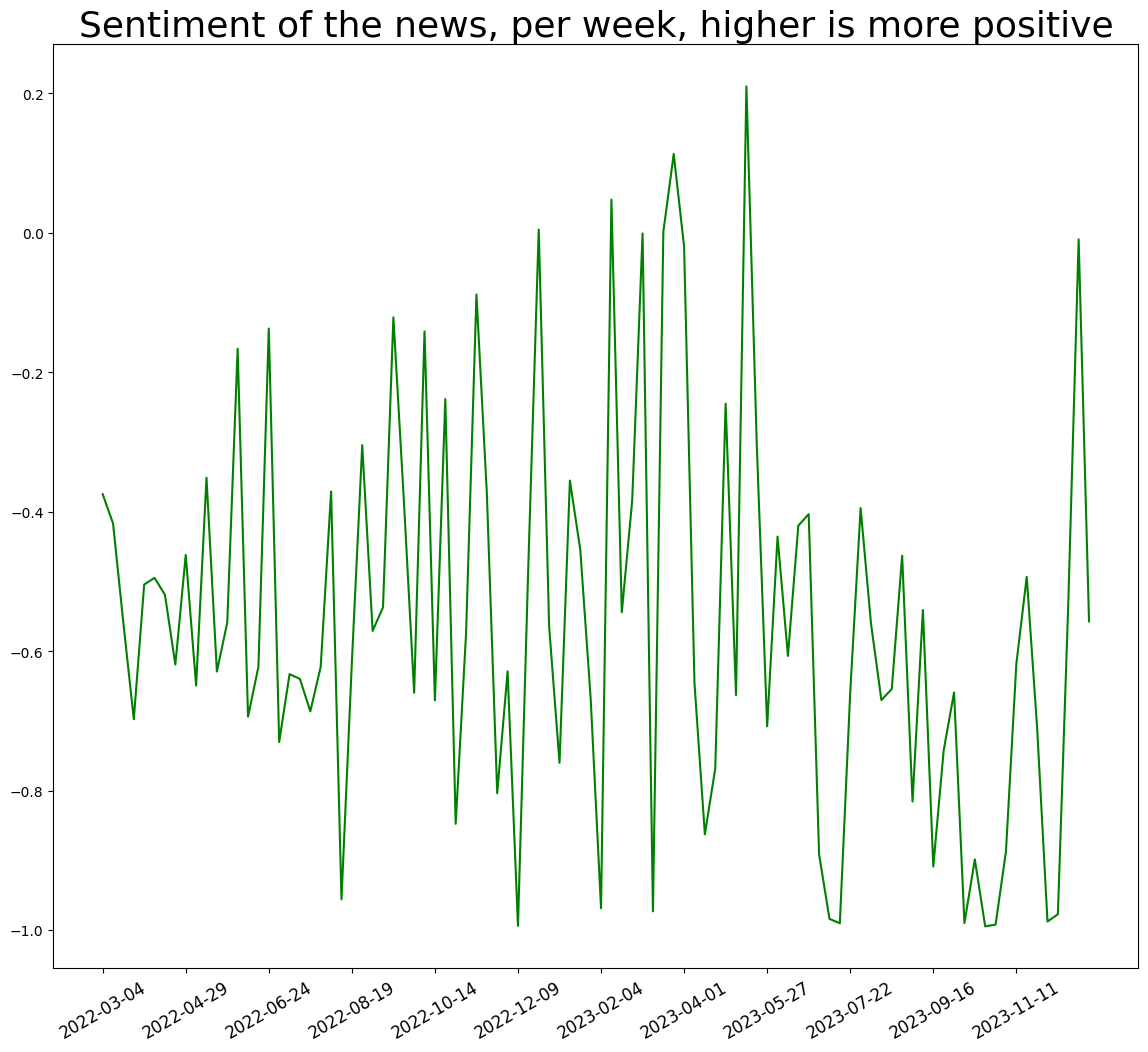

In [13]:
plt.figure(figsize=(14, 12))
df["sentiment"].plot(color='green')
plt.xticks(range(len(df["weekLabels"])), df["weekLabels"], size='large')
plt.xticks(rotation = 30)
plt.locator_params(axis='x', nbins=numberOfBins)
plt.title('Sentiment of the news, per week, higher is more positive', fontsize = 26)

# Finish!
You have made it to the finish, thank you. Please upvote if you liked it :)